<a href="https://www.kaggle.com/code/vamsimohanbangale/onlinepaymentfrauddetection?scriptVersionId=251051710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from tabulate import tabulate
import random
import tensorflow as tf

2025-07-17 16:12:25.911305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 16:12:25.911457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 16:12:26.073732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/online-payment-fraud-detection/onlinefraud.csv')

df.drop('isFlaggedFraud', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [4]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
5594563,394,CASH_OUT,187722.18,C29678337,0.00,0.00,C772285287,1519339.36,1707061.54,0
2538058,205,TRANSFER,1803018.91,C757378336,0.00,0.00,C270443867,1803499.76,3471867.71,0
2392002,201,CASH_IN,210954.33,C811748134,1869882.69,2080837.02,C1901561737,273501.10,62546.78,0
2269505,187,CASH_OUT,282392.44,C495533366,0.00,0.00,C310249090,556266.82,838659.26,0
478230,19,CASH_OUT,179277.82,C1780062484,0.00,0.00,C721290614,180890.58,360168.39,0


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
] 

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='github',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----|----------------|-------------|-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [7]:
# Downcast numerical columns with smaller dtype
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [8]:
# Check duplicate values
df.duplicated().sum()

0

In [9]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

In [10]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
245        4
28         4
655        4
112        2
662        2
Name: count, Length: 743, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0, 0.5, 'Number of transactions')

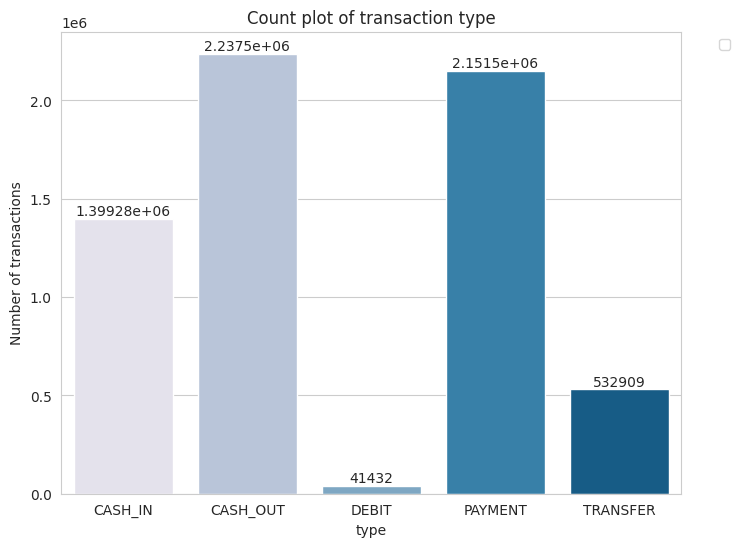

In [11]:
ax = sns.countplot(x='type', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of transaction amount')

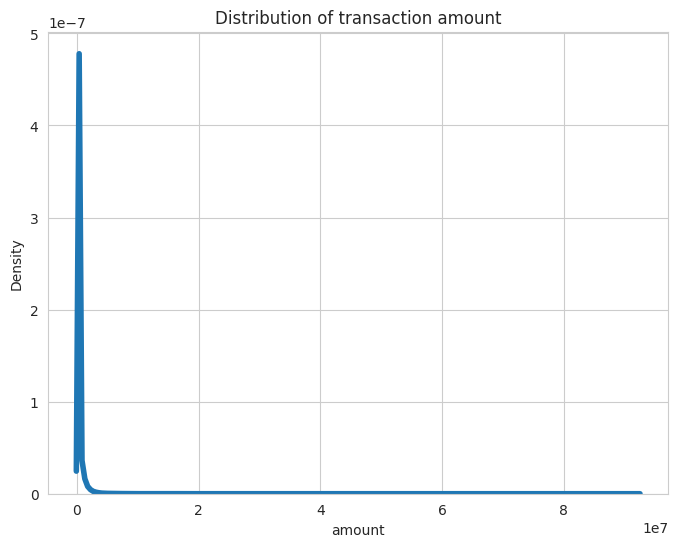

In [12]:
sns.kdeplot(df['amount'], linewidth=4)
plt.title('Distribution of transaction amount')

In [13]:
df['nameOrig'].value_counts()

nameOrig
C1530544995    3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
              ..
C1567523029    1
C644777639     1
C1256645416    1
C1231536757    1
C1971151096    1
Name: count, Length: 6353307, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of transaction amount')

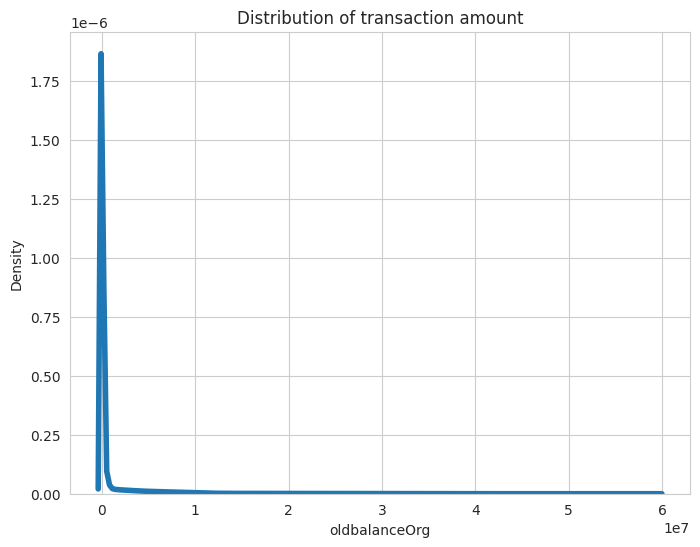

In [14]:
sns.kdeplot(df['oldbalanceOrg'], linewidth=4)
plt.title('Distribution of transaction amount')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of transaction amount')

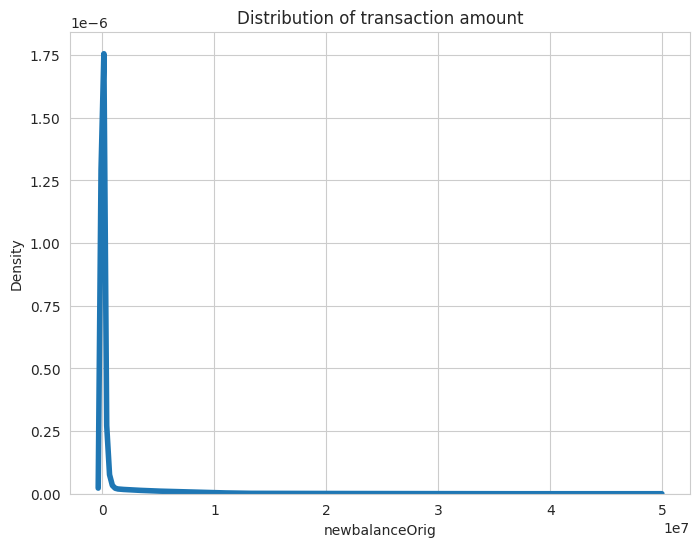

In [15]:
sns.kdeplot(df['newbalanceOrig'], linewidth=4)
plt.title('Distribution of transaction amount')

In [16]:
df['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
              ... 
M295304806       1
M33419717        1
M1940055334      1
M335107734       1
M1757317128      1
Name: count, Length: 2722362, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of transaction amount')

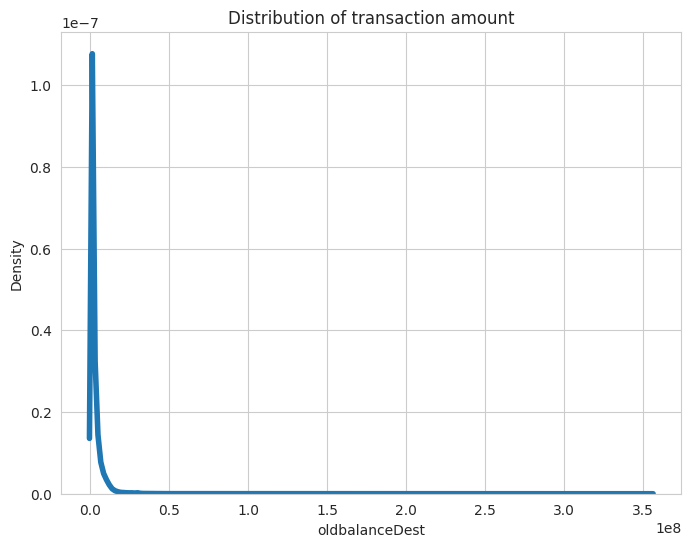

In [17]:
sns.kdeplot(df['oldbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of transaction amount')

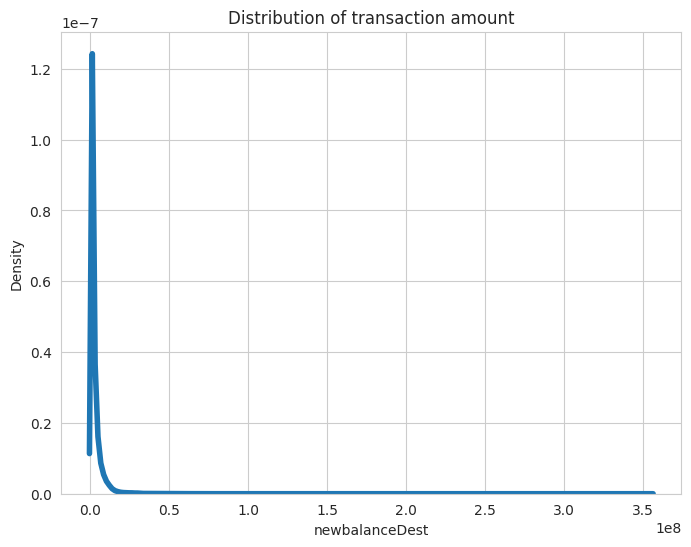

In [18]:
sns.kdeplot(df['newbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

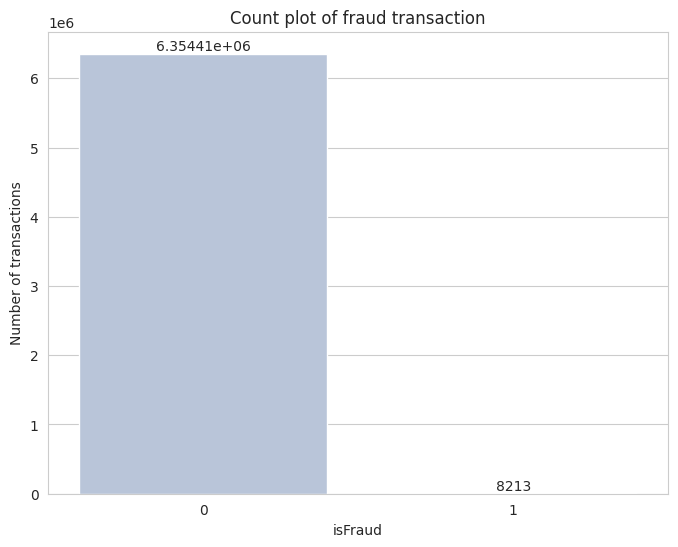

In [19]:
ax = sns.countplot(x='isFraud', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction')
plt.ylabel('Number of transactions')

del ax

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_24/3891187721.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df.groupby(['type', 'isFraud']).si

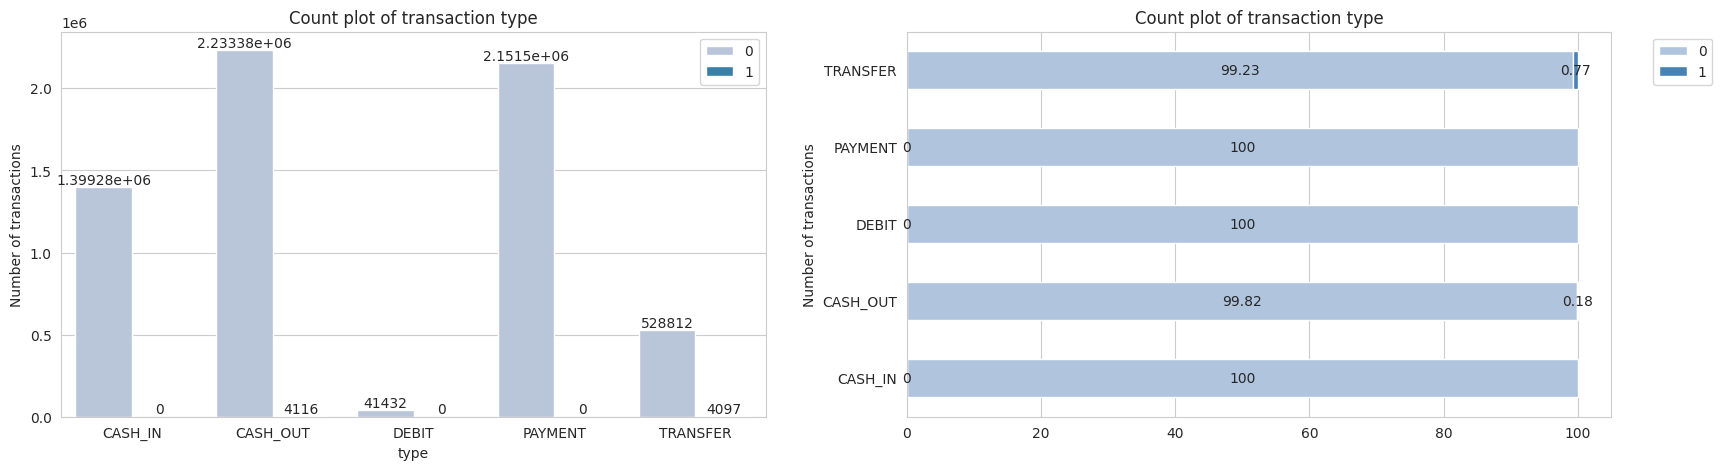

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(x='type', data=df, hue='isFraud', palette='PuBu', ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].set_title('Count plot of transaction type')
ax[0].legend(loc='best')
ax[0].set_ylabel('Number of transactions')

df2 = df.groupby(['type', 'isFraud']).size().unstack()
df2.apply(lambda x : round(x/sum(x)*100, 2), axis=1).plot(kind='barh', stacked=True, color=['lightsteelblue', 'steelblue'], ax=ax[1])
for container in ax[1].containers:
    ax[1].bar_label(container, label_type='center')
ax[1].set_title('Count plot of transaction type')
ax[1].legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax[1].set_ylabel('Number of transactions')
ax[1].grid(axis='y')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0, 0.5, 'Number of transactions')

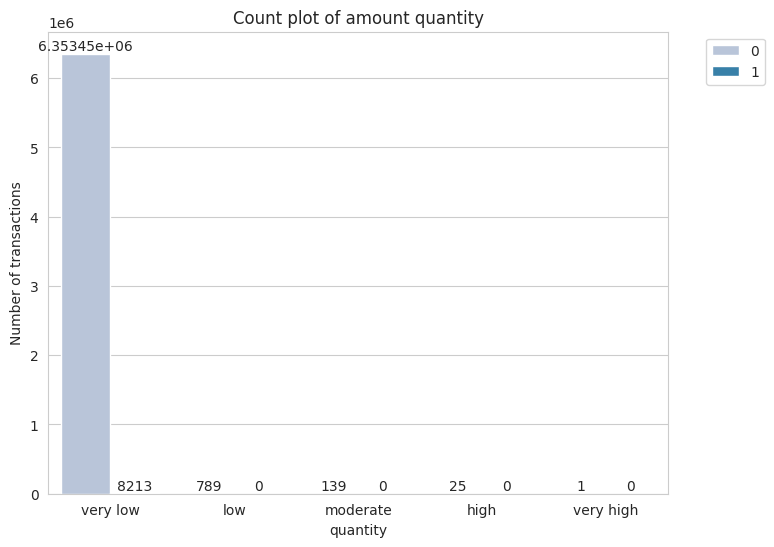

In [21]:
df['quantity'] = pd.cut(df['amount'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='quantity', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of amount quantity')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

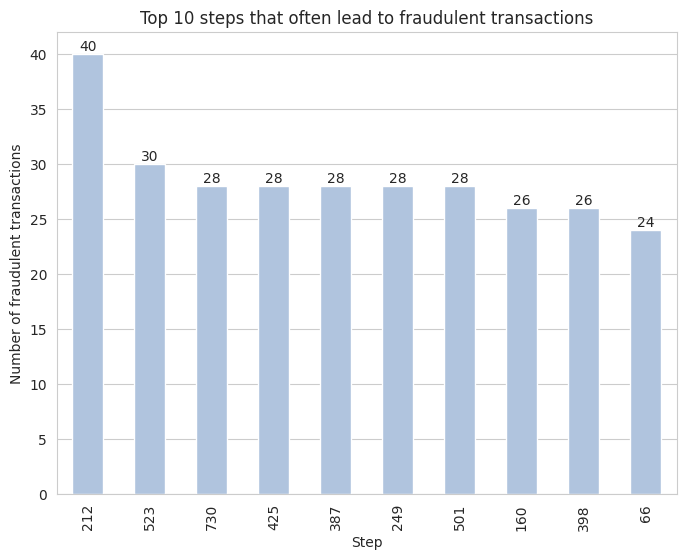

In [22]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Step')
plt.grid(axis='x')

del ax, df2

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 0, 'Initial customers pre-transaction balance amount')

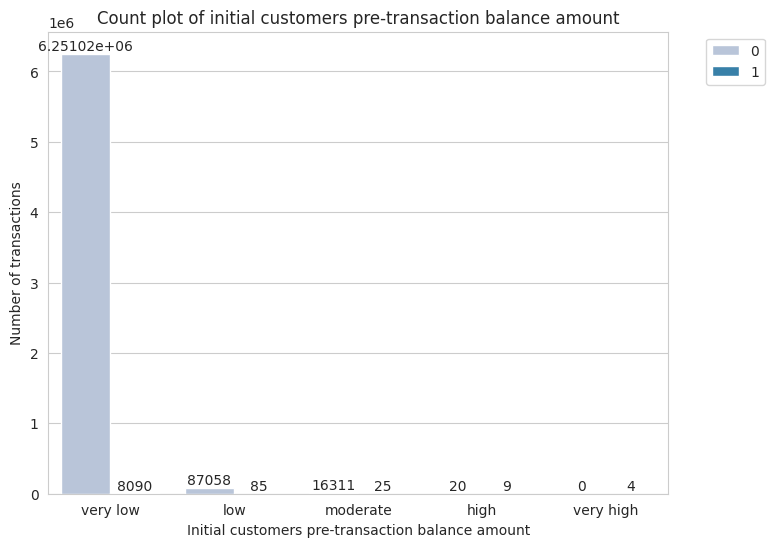

In [23]:
df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceOrg_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of initial customers pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Initial customers pre-transaction balance amount')

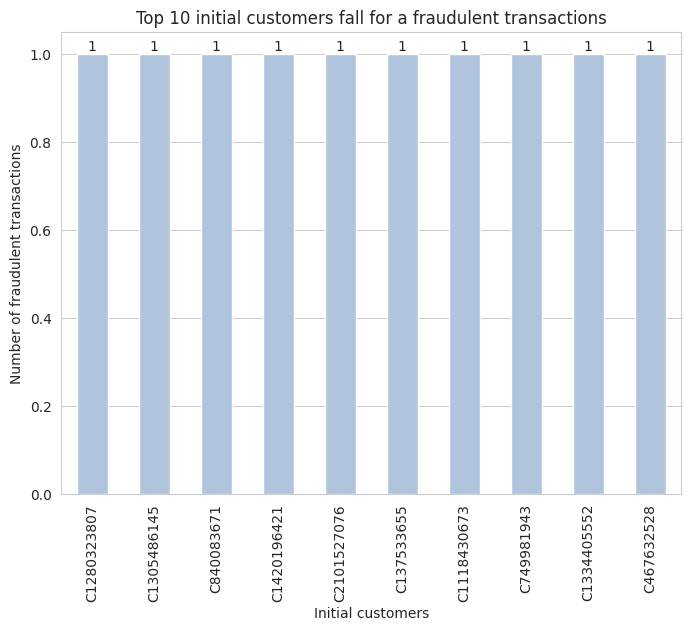

In [24]:
df2 = df1['nameOrig'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 initial customers fall for a fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Initial customers')
plt.grid(axis='x')

del ax, df2

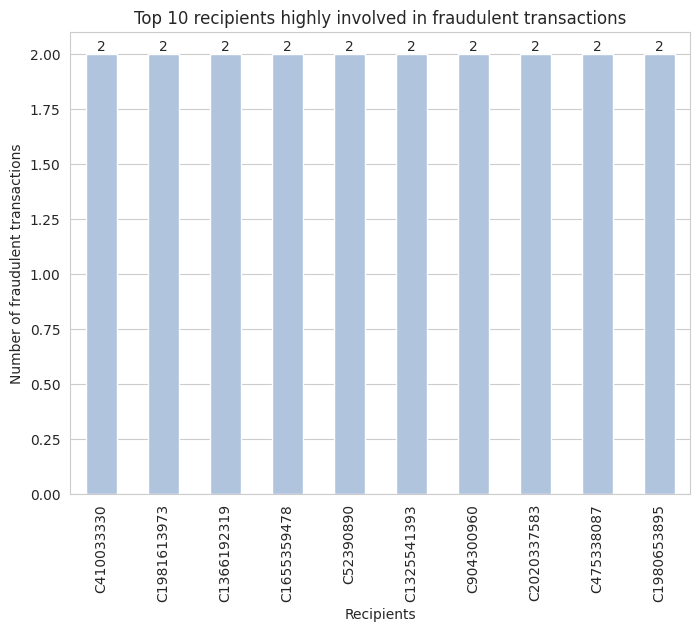

In [25]:
df2 = df1['nameDest'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 recipients highly involved in fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Recipients')
plt.grid(axis='x')

del ax, df2

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 0, 'Recipient pre-transaction balance amount')

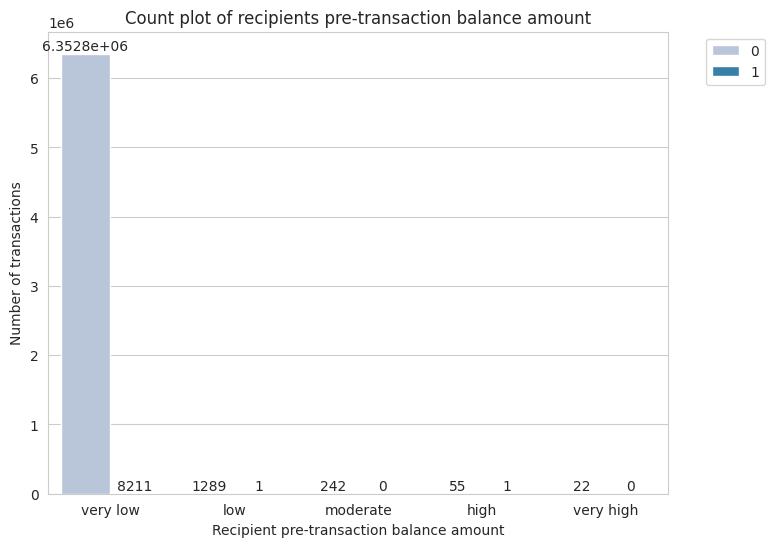

In [26]:
df['oldbalanceDest_amt'] = pd.cut(df['oldbalanceDest'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceDest_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of recipients pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Recipient pre-transaction balance amount')

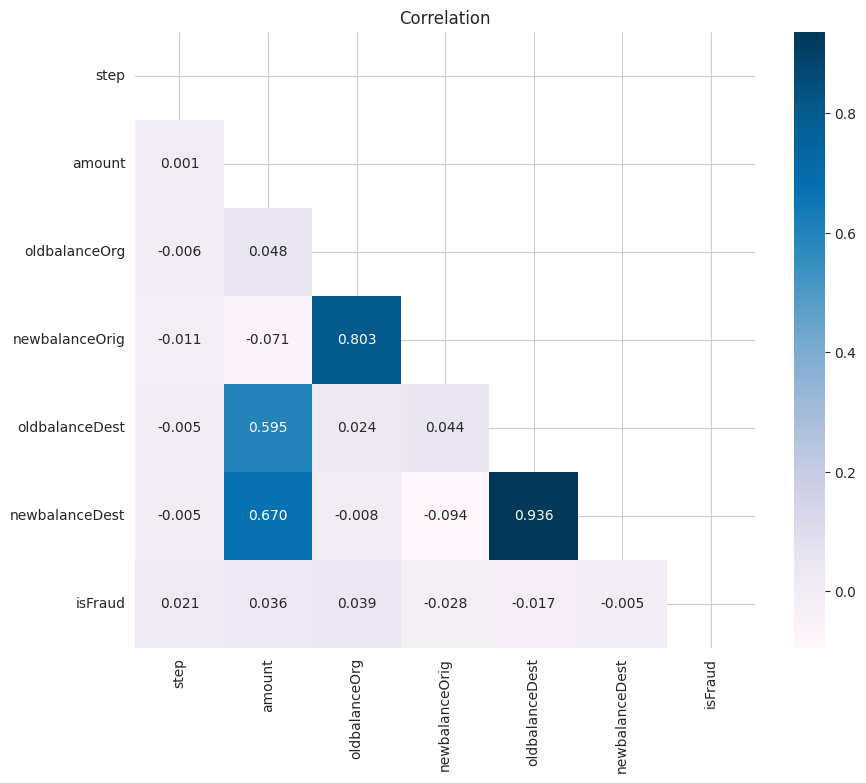

In [27]:
df_numeric = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = df_numeric.corr('spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, cbar=True, annot=True, mask=mask, fmt='.3f', cmap='PuBu')

# Add a title
plt.title('Correlation')

# Show the plot
plt.show()

In [28]:
# Data preprocessing
df['type'] = df['type'].map({'PAYMENT':0, 'CASH_IN':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4})

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay


seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


X = df.copy()
X.drop(['nameOrig', 'newbalanceOrig', 'nameDest', 'newbalanceDest', 'quantity', 'oldbalanceOrg_amt', 'oldbalanceDest_amt'], axis=1, inplace=True)
y = X.pop('isFraud')


# Stratified train-test split
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_idx, test_idx in skfold.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


sc = StandardScaler()
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)


X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

In [30]:
from sklearn.impute import SimpleImputer
def model_comparison_evaluate(classifiers, X, y):
    print('K-Fold Cross-Validation:\n')
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    for name, model in classifiers.items():
        print('{}:'.format(name))
        
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        for score in scoring:
            scores = cross_val_score(model, X_imputed, y, scoring=score, cv=skfold, n_jobs=-1)
            print('Mean {} score: {:.3f} ({:.3f})'.format(score, scores.mean(), scores.std()))
            
        print('\n')

In [31]:
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced', random_state=seed),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=seed)
}

In [32]:
model_comparison_evaluate(classifiers, X_train, y_train)

K-Fold Cross-Validation:

Random Forest Classifier:


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean accuracy score: 0.985 (0.003)
Mean precision score: 0.975 (0.006)
Mean recall score: 0.996 (0.002)
Mean f1 score: 0.985 (0.003)
Mean roc_auc score: 0.998 (0.000)


Logistic Regression:
Mean accuracy score: 0.848 (0.007)
Mean precision score: 0.843 (0.008)
Mean recall score: 0.856 (0.005)
Mean f1 score: 0.849 (0.006)
Mean roc_auc score: 0.927 (0.004)




Random Forest Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      0.98      0.99   1270881
    Fraud [1]       0.05      1.00      0.09      1643

     accuracy                           0.98   1272524
    macro avg       0.52      0.99      0.54   1272524
 weighted avg       1.00      0.98      0.99   1272524
 



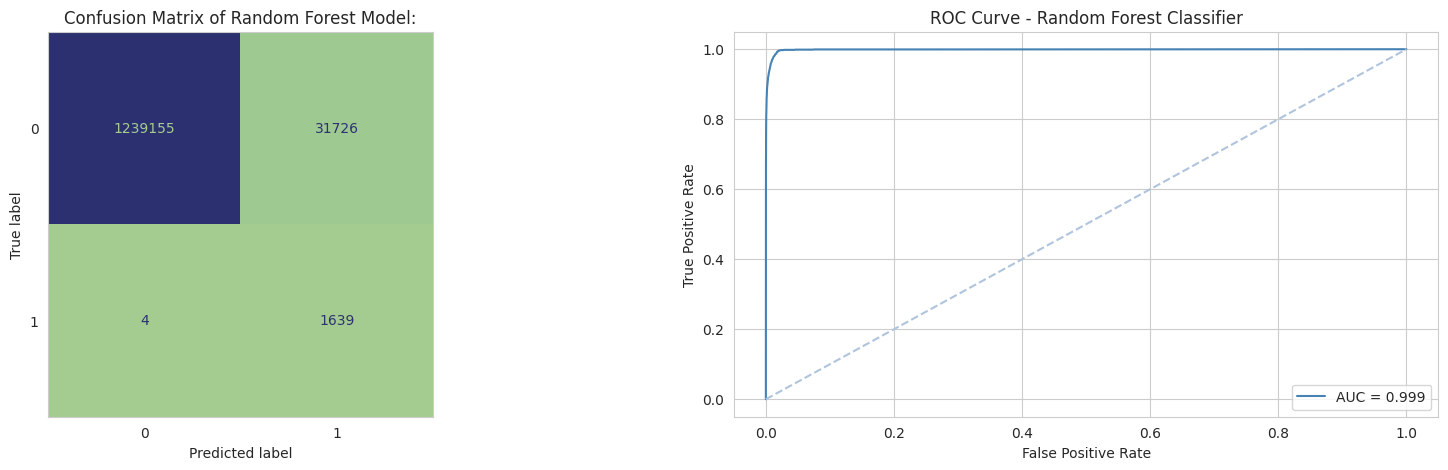

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are already defined

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the model
model = RandomForestClassifier(class_weight='balanced', random_state=seed)
model.fit(X_train_imputed, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_imputed)
y_pred_score = model.predict_proba(X_test_imputed)[:, 1]

print('Random Forest Classifier:')
print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Confusion Matrix
ax[0].set_title('Confusion Matrix of Random Forest Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Random Forest Classifier')
ax[1].plot(fpr, tpr, label='AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0, 1], [0, 1], '--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

plt.show()
